# 预测

## 波士顿棕熊队问题
在2010-2011的国家冰球联盟（NHL）总决赛中，我喜爱的7个赛季冠军波士顿棕熊队与我嗤之以鼻的温哥华加拿大人队对决。波士顿以0:1和2:3输掉了前两场比赛，以8:1和4:0赢了后续两场比赛。那么在赛季的这个时间点上，考虑波士顿赢下一场比赛的可能性是多少？赢得总冠军的概率是多少？

我们可以假设，长期来看每队都有一个单场平均得分数，记为 $\lambda$。  
根据这些假设，我回答这个问题的策略是：
1. 从以前的比赛统计资料，为 $\lambda$ 选择一个先验分布。（高斯分布）
2. 由前四场比赛的得分估计每队的 $\lambda$ 。
3. 用 $\lambda$ 的后验分布来计算每队的进球分布，得分差的分布，还有每个球队下一场比赛获胜的概率。
4. 计算每个队赢得赛季冠军的概率。

### 先验分布
选择一个先验分布，从统计数字包括每队在2010-2011赛季平均每场进球的分布，大致是均值2.8，标准差为0.3的高斯分布。

### 泊松过程
在数理统计上，**过程**是一个物理系统的随机模型（“随机”是指该模型包含某种随机量）。  
一个**伯努利过程**是一个事件序列的模型，对于一系列硬币翻转事件等，伯努利过程是一个天然的模型。  
**泊松过程**是伯努利过程的连续版本，一个事件在任何时间点上发生的概率是相同的。  
泊松过程可应用于到达商店的客户，公交车到站，或者冰球比赛的进球得分上。

In [9]:
from thinkbayes import Suite, MakeGaussianPmf, EvalPoissonPmf
class Hockey(Suite):
    def __init__(self, name=''):
        # def MakeGaussianPmf(mu, sigma, num_sigmas, n=101)
        pmf = MakeGaussianPmf(2.8, 0.3, 4)
        Suite.__init__(self, pmf, name=name)
    
    # 计算一个给定lam值的球队在一场比赛中进k球的可能性
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

每个假设都是 $\lambda$ 的一个可能的值；数据得分是 $k$

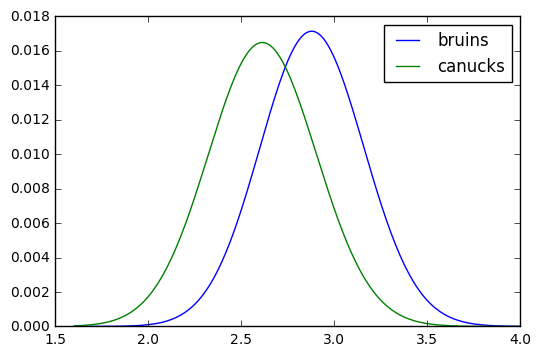

In [33]:
suite1 = Hockey('bruins')
suite1.UpdateSet([0, 2, 8, 4])
suite2 = Hockey('canucks')
suite2.UpdateSet([1, 3, 1, 0])

import matplotlib.pyplot as plt
x_1 = [item[0] for item in sorted(suite1.Items())]
prob_1 = [item[1] for item in sorted(suite1.Items())]
x_2 = [item[0] for item in sorted(suite2.Items())]
prob_2 = [item[1] for item in sorted(suite2.Items())]
plt.figure()
plt.plot(x_1, prob_1, label="bruins")
plt.plot(x_2, prob_2, label="canucks")
plt.legend()
plt.show()

给定 $\lambda$ 的后验分布结果。根据前四场比赛的数据，最有可能的 $\lambda$ 值加拿大人对是2.6，棕熊队是2.9。

In [28]:
from thinkbayes import Pmf, MakeMixture

def MakePoissonPmf(lam, high):
    # 分段泊松分布
    pmf = Pmf()
    for k in xrange(0, high+1):
        p = EvalPoissonPmf(k, lam)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf

# 计算对于所有可能的lam分布，0-10分的对应分布
def MakeGoalPmf(suite):
    # 元Pmf，包含多个Pmfs值的Pmf对象
    metapmf = Pmf()
    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, 10)
        metapmf.Set(pmf, prob)
    mix = MakeMixture(metapmf)
    return mix

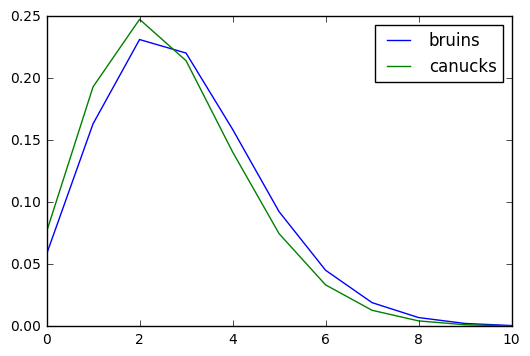

In [32]:
suite1_10 = MakeGoalPmf(suite1)
suite2_10 = MakeGoalPmf(suite2)

import matplotlib.pyplot as plt
x_1 = [item[0] for item in sorted(suite1_10.Items())]
prob_1 = [item[1] for item in sorted(suite1_10.Items())]
x_2 = [item[0] for item in sorted(suite2_10.Items())]
prob_2 = [item[1] for item in sorted(suite2_10.Items())]
plt.figure()
plt.plot(x_1, prob_1, label="bruins")
plt.plot(x_2, prob_2, label="canucks")
plt.legend()
plt.show()

棕熊队和加拿大人队的进球分布

## 获胜的概率

In [36]:
# 减法运算符调用Pmf.__sub__，枚举一对值并计算差值
diff = suite1_10 - suite2_10
p_win = diff.ProbGreater(0)
p_loss = diff.ProbLess(0)
p_tie = diff.Prob(0)
print("p_win", p_win, "p_loss", p_loss, "p_tie", p_tie)

('p_win', 0.45799649207235454, 'p_loss', 0.3702934089545194, 'p_tie', 0.17171009897312486)


## 突然死亡法则
在规定比赛时间结束时如果出现平局，两队会进行加时赛，直到其中一队得分。由于一旦进球比赛就会马上结束，这种加时赛形式被称为“突然死亡法则”。

假设的进球是一个泊松过程，意味着得分之间的时间服从指数分布。**?**

In [39]:
from thinkbayes import MakeExponentialPmf
def MakeGoalTimePmf(suite):
    metapmf = Pmf()
    for lam, prob in suite.Items():
        pmf = MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)
    mix = MakeMixture(metapmf)
    return mix

In [44]:
time_dist1 = MakeGoalTimePmf(suite1)
time_dist2 = MakeGoalTimePmf(suite2)
from thinkbayes import PmfProbLess
# 加时赛获胜
p_overtime = PmfProbLess(time_dist1, time_dist2)
print("p_overtime", p_overtime)
# 赢得比赛
p_win = p_win + p_tie*p_overtime
print("p_win", p_win)
# 赢得总冠军，七局四胜制
p_series = p_win**2 + 2*(1-p_win)*p_finalwin**2
print("p_series", p_series)

('p_overtime', 0.52278293220337735)
('p_win', 0.54776360110245692)
('p_series', 0.57142746956374857)


本实验对先验的选择还是很敏感的，值得我们投入一些精力来获得合适的前验概率。